In [1]:
## IMPORT PACKAGES

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import GRU
from keras.layers import concatenate
from keras import optimizers
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import math
import numpy as np

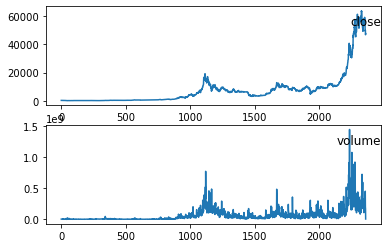

In [2]:
## LOAD DATA AND PREPROCESS

data = read_csv('Bitstamp_BTCUSD_d.csv', header=1, index_col=1) # load dataset and plot (data starts Nov. 28, 2014)
data = data.iloc[0:,2:] # prepare table
data = DataFrame(data.iloc[::-1]) # reverse table and turn to Data Frame
data['volume'] = data['Volume BTC'] + data['Volume USD'] # preprocess (add volume btc and volume usd)
data = data[['close','volume']] # prepare new table with only close and volume USD
pyplot.figure() # plot only close and volume
for i in range(len(data.columns)):
    pyplot.subplot(len(data.columns), 1, i+1)
    pyplot.plot(data.values[:, i])
    pyplot.title(data.columns[i], y=0.75, loc='right')
pyplot.show()

In [3]:
## TRAINING

# Set Parameters
timetrain = 1494 # number of days for training (default 4 years until 2018)
timeval = 365 # number of days for validation (default 1 year from 2018-2019)
timetrail = 90 # number of days before to look at
timefuture = 30 # predict how many days in the future

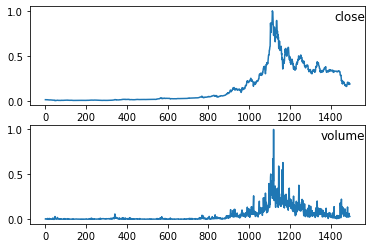

In [4]:
# Get train data
traindf = data.iloc[:timetrain+1,] # get train data
trainscaler = MinMaxScaler(feature_range=(0, 1)) # initialize scaler
trainscaled = DataFrame(trainscaler.fit_transform(traindf)) # scale data for better learning
trainscaled.columns = ('close','volume') # give label to columns
pyplot.figure() # plot training data
for i in range(len(trainscaled.columns)):
    pyplot.subplot(len(trainscaled.columns), 1, i+1)
    pyplot.plot(trainscaled.iloc[:,i])
    pyplot.title(trainscaled.columns[i], y=0.8, loc='right')
pyplot.show()

In [5]:
# Prepare time shifted train data table
trainscaled.index = traindf.index # give label to rows
newcols, newcols_names = list(), list() # initialize time shifted data table
for i in range(timetrail, 0, -1):  # prepare time shifted data table
    newcols.append(trainscaled.shift(i))
    newcols_names.append(('close(t-%d)' % i,'volume(t-%d)' % i))
trainshifted = concat(newcols, axis=1) # finalize time shifted data table
trainshifted.columns = list(sum(newcols_names, ())) # give label to columns
trainshifted.tail()

,close(t-90),volume(t-90),close(t-89),volume(t-89),close(t-88),volume(t-88),close(t-87),volume(t-87),close(t-86),volume(t-86),...,close(t-5),volume(t-5),close(t-4),volume(t-4),close(t-3),volume(t-3),close(t-2),volume(t-2),close(t-1),volume(t-1)
date,,,,,,,,,,,,,,,,,,,,,
27/12/2018 0:00,0.338949,0.065417,0.337299,0.028813,0.338268,0.021211,0.336869,0.040809,0.333127,0.034645,...,0.200722,0.039684,0.198774,0.023544,0.203618,0.062814,0.190163,0.057770,0.191740,0.049657
28/12/2018 0:00,0.337299,0.028813,0.338268,0.021211,0.336869,0.040809,0.333127,0.034645,0.330855,0.039921,...,0.198774,0.023544,0.203618,0.062814,0.190163,0.057770,0.191740,0.049657,0.180265,0.055119
29/12/2018 0:00,0.338268,0.021211,0.336869,0.040809,0.333127,0.034645,0.330855,0.039921,0.335627,0.032495,...,0.203618,0.062814,0.190163,0.057770,0.191740,0.049657,0.180265,0.055119,0.195680,0.065685
30/12/2018 0:00,0.336869,0.040809,0.333127,0.034645,0.330855,0.039921,0.335627,0.032495,0.337443,0.032450,...,0.190163,0.057770,0.191740,0.049657,0.180265,0.055119,0.195680,0.065685,0.187297,0.033297
31/12/2018 0:00,0.333127,0.034645,0.330855,0.039921,0.335627,0.032495,0.337443,0.032450,0.335444,0.017141,...,0.191740,0.049657,0.180265,0.055119,0.195680,0.065685,0.187297,0.033297,0.193095,0.028496


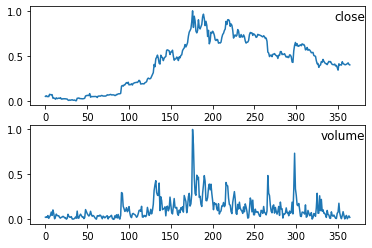

In [6]:
# Get validation data
valdf = data.iloc[timetrain+1:(timetrain+1+timeval),] # get validation data
valscaler = MinMaxScaler(feature_range=(0, 1)) # initialize scaler
valscaled = DataFrame(valscaler.fit_transform(valdf)) # scale data for better learning
valscaled.columns = ('close','volume') # give label to columns
pyplot.figure() # plot validation data
for i in range(len(valscaled.columns)):
    pyplot.subplot(len(valscaled.columns), 1, i+1)
    pyplot.plot(valscaled.iloc[:,i])
    pyplot.title(valscaled.columns[i], y=0.8, loc='right')
pyplot.show()

In [7]:
# Prepare time shifted validation data table
valscaled.index = valdf.index # give label to rows
newcols, newcols_names = list(), list() # initialize time shifted data table
for i in range(timetrail, 0, -1): # prepare time shifted data table
    newcols.append(valscaled.shift(i))
    newcols_names.append(('close(t-%d)' % i,'volume(t-%d)' % i))
valshifted = concat(newcols, axis=1) # finalize time shifted data table
valshifted.columns = list(sum(newcols_names, ())) # give label to columns
valshifted.tail()

,close(t-90),volume(t-90),close(t-89),volume(t-89),close(t-88),volume(t-88),close(t-87),volume(t-87),close(t-86),volume(t-86),...,close(t-5),volume(t-5),close(t-4),volume(t-4),close(t-3),volume(t-3),close(t-2),volume(t-2),close(t-1),volume(t-1)
date,,,,,,,,,,,,,,,,,,,,,
27/12/2019 0:00,0.508172,0.090729,0.490343,0.072409,0.516579,0.147693,0.518729,0.160447,0.524420,0.068795,...,0.434084,0.041543,0.413843,0.084835,0.407081,0.045557,0.401253,0.004363,0.400469,0.028708
28/12/2019 0:00,0.490343,0.072409,0.516579,0.147693,0.518729,0.160447,0.524420,0.068795,0.510457,0.132352,...,0.413843,0.084835,0.407081,0.045557,0.401253,0.004363,0.400469,0.028708,0.406504,0.042918
29/12/2019 0:00,0.516579,0.147693,0.518729,0.160447,0.524420,0.068795,0.510457,0.132352,0.501269,0.089224,...,0.407081,0.045557,0.401253,0.004363,0.400469,0.028708,0.406504,0.042918,0.411759,0.005834
30/12/2019 0:00,0.518729,0.160447,0.524420,0.068795,0.510457,0.132352,0.501269,0.089224,0.500548,0.057728,...,0.401253,0.004363,0.400469,0.028708,0.406504,0.042918,0.411759,0.005834,0.421098,0.021725
31/12/2019 0:00,0.524420,0.068795,0.510457,0.132352,0.501269,0.089224,0.500548,0.057728,0.470107,0.088193,...,0.400469,0.028708,0.406504,0.042918,0.411759,0.005834,0.421098,0.021725,0.403810,0.038120


In [8]:
# Train Model

# prepare train data
trainX, trainY = trainshifted.iloc[timetrail:trainshifted.shape[0]-(timefuture-1),].values, DataFrame(trainscaled['close'].shift(-(timefuture-1)).iloc[timetrail:trainshifted.shape[0]-(timefuture-1),].values) # set train attributes and response
trainXsh = trainX.reshape((trainX.shape[0], timetrail, len(trainscaled.columns))) # reshape training data for time-series

# prepare validation data
valX, valY = valshifted.iloc[timetrail:valshifted.shape[0]-(timefuture-1),].values, DataFrame(valscaled['close'].shift(-(timefuture-1)).iloc[timetrail:valshifted.shape[0]-(timefuture-1),].values) # set train attributes and response
valXsh = valX.reshape((valX.shape[0], timetrail, len(valscaled.columns))) # reshape validation data for time-series

# prepare LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(trainXsh.shape[1], trainXsh.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=1e-3, decay=1e-4))

# fit LSTM model
history = model.fit(trainXsh, trainY, epochs=16, batch_size=32, validation_data=(valXsh, valY), verbose=1, shuffle=False)

Epoch 1/16
43/43 [==============================] - 15s 342ms/step - loss: 0.0263 - val_loss: 0.1574
Epoch 2/16
43/43 [==============================] - 9s 211ms/step - loss: 0.0299 - val_loss: 0.0270
Epoch 3/16
43/43 [==============================] - 9s 214ms/step - loss: 0.0179 - val_loss: 0.0309
Epoch 4/16
43/43 [==============================] - 9s 219ms/step - loss: 0.0125 - val_loss: 0.0596
Epoch 5/16
43/43 [==============================] - 9s 205ms/step - loss: 0.0129 - val_loss: 0.0326
Epoch 6/16
43/43 [==============================] - 10s 221ms/step - loss: 0.0110 - val_loss: 0.0320
Epoch 7/16
43/43 [==============================] - 8s 197ms/step - loss: 0.0088 - val_loss: 0.0313
Epoch 8/16
43/43 [==============================] - 8s 183ms/step - loss: 0.0091 - val_loss: 0.0301
Epoch 9/16
43/43 [==============================] - 8s 180ms/step - loss: 0.0089 - val_loss: 0.0307
Epoch 10/16
43/43 [==============================] - 9s 213ms/step - loss: 0.0088 - val_loss: 0.03

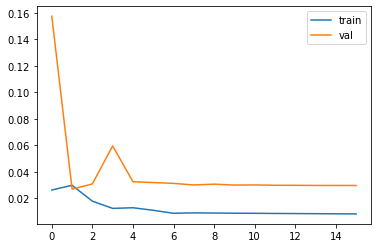

In [9]:
# plot training loss vs validation loss to check for overfitting
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

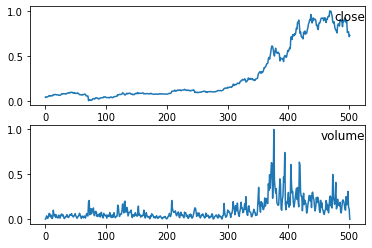

In [10]:
## PREDICTION

testdf = data.iloc[(timetrain+1+timeval):,] # get test data
testscaler = MinMaxScaler(feature_range=(0, 1)) # initialize scaler
testscaled = DataFrame(testscaler.fit_transform(testdf)) # scale data for better learning
testscaled.columns = ('close','volume') # give label to columns
pyplot.figure() # plot training data
for i in range(len(testscaled.columns)):
    pyplot.subplot(len(testscaled.columns), 1, i+1)
    pyplot.plot(testscaled.iloc[:,i])
    pyplot.title(testscaled.columns[i], y=0.8, loc='right')
pyplot.show()

In [11]:
# Prepare time shifted test data table
testscaled.index = testdf.index # give label to rows
newcols, newcols_names = list(), list() # initialize time shifted data table
for i in range(timetrail, 0, -1): # prepare time shifted data table
    newcols.append(testscaled.shift(i))
    newcols_names.append(('close(t-%d)' % i,'volume(t-%d)' % i))
testshifted = concat(newcols, axis=1) # finalize time shifted data table
testshifted.columns = list(sum(newcols_names, ())) # give label to columns
testshifted.tail()

,close(t-90),volume(t-90),close(t-89),volume(t-89),close(t-88),volume(t-88),close(t-87),volume(t-87),close(t-86),volume(t-86),...,close(t-5),volume(t-5),close(t-4),volume(t-4),close(t-3),volume(t-3),close(t-2),volume(t-2),close(t-1),volume(t-1)
date,,,,,,,,,,,,,,,,,,,,,
12/05/2021 0:00,0.734635,0.309278,0.724662,0.192978,0.721812,0.136630,0.746232,0.172280,0.733972,0.226982,...,0.894713,0.165249,0.922011,0.116524,0.910440,0.101415,0.869152,0.252133,0.884188,0.162191
13/05/2021 0:00,0.724662,0.192978,0.721812,0.136630,0.746232,0.172280,0.733972,0.226982,0.754815,0.282384,...,0.922011,0.116524,0.910440,0.101415,0.869152,0.252133,0.884188,0.162191,0.758562,0.214834
14/05/2021 0:00,0.721812,0.136630,0.746232,0.172280,0.733972,0.226982,0.754815,0.282384,0.806034,0.343141,...,0.910440,0.101415,0.869152,0.252133,0.884188,0.162191,0.758562,0.214834,0.763814,0.310290
15/05/2021 0:00,0.746232,0.172280,0.733972,0.226982,0.754815,0.282384,0.806034,0.343141,0.795907,0.223190,...,0.869152,0.252133,0.884188,0.162191,0.758562,0.214834,0.763814,0.310290,0.766972,0.135471
16/05/2021 0:00,0.733972,0.226982,0.754815,0.282384,0.806034,0.343141,0.795907,0.223190,0.870989,0.355191,...,0.884188,0.162191,0.758562,0.214834,0.763814,0.310290,0.766972,0.135471,0.712963,0.113775


In [12]:
# Produce and Evaluate Predictions

# prepare test data
testX, testY = testshifted.iloc[timetrail:,].values, DataFrame(testscaled['close'].shift(-(timefuture-1)).iloc[timetrail:,].values)
testXsh = testX.reshape((testX.shape[0], timetrail, len(testscaled.columns))) # reshape test data for time-series

predY = model.predict(testXsh) # make predictions using model
invpredY = testscaler.inverse_transform(concatenate((predY, testshifted.iloc[timetrail:,-1:]), axis=1))[:,0] # revert the scaling to get actual values
shiftedinvpredY = np.append(np.repeat(np.nan, (timefuture-1)),invpredY)
actualY = testdf.iloc[timetrail:,0].values # extract actual values from original data
shiftedactualY = np.append(actualY,np.repeat(np.nan, (timefuture-1)))
rmse = math.sqrt(mean_squared_error(shiftedactualY[(timefuture-1):(shiftedactualY.shape[0]-(timefuture-1)),], shiftedinvpredY[(timefuture-1):(shiftedinvpredY.shape[0]-(timefuture-1)),])) # calculate rmse
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8240.609


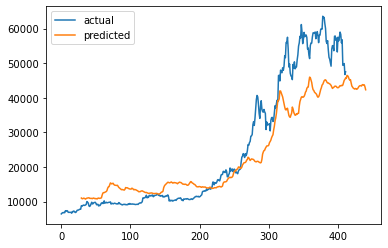

In [13]:
# compare predicted to actual (whole test data, note that this is a daily prediction)
pyplot.plot(shiftedactualY, label='actual')
pyplot.plot(shiftedinvpredY, label='predicted')
pyplot.legend()
pyplot.show()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Test RMSE: 6924.099


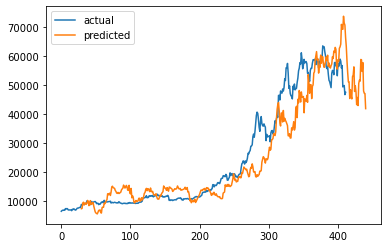

In [14]:
# LINEAR REGRESSION

LR = LinearRegression().fit(np.vstack((trainX,valX)),np.vstack((trainY,valY))) # fit linear regression model

LRpredY = LR.predict(testX) # make predictions using model
LRinvpredY = testscaler.inverse_transform(concatenate((LRpredY.reshape(LRpredY.shape[0],1), testshifted.iloc[timetrail:,-1:]), axis=1))[:,0] # revert the scaling to get actual values
LRshiftedinvpredY = np.append(np.repeat(np.nan, (timefuture-1)),LRinvpredY)
actualY = testdf.iloc[timetrail:,0].values # extract actual values from original data
shiftedactualY = np.append(actualY,np.repeat(np.nan, (timefuture-1)))
LRrmse = math.sqrt(mean_squared_error(shiftedactualY[(timefuture-1):(shiftedactualY.shape[0]-(timefuture-1)),], LRshiftedinvpredY[(timefuture-1):(shiftedinvpredY.shape[0]-(timefuture-1)),])) # calculate rmse
print('Test RMSE: %.3f' % LRrmse) 
    
# compare predicted to actual (whole test data, note that this is a daily prediction)
pyplot.plot(shiftedactualY, label='actual')
pyplot.plot(LRshiftedinvpredY, label='predicted')
pyplot.legend()
pyplot.show()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Test RMSE: 10114.310


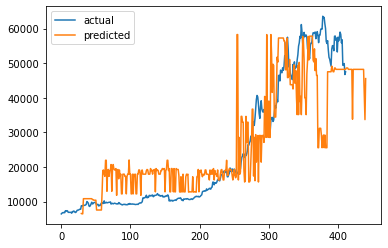

In [15]:
# DECISION TREE

DT = tree.DecisionTreeRegressor().fit(np.vstack((trainX,valX)),np.vstack((trainY,valY))) # fit decision tree

DTpredY = DT.predict(testX) # make predictions using model
DTinvpredY = testscaler.inverse_transform(concatenate((DTpredY.reshape(DTpredY.shape[0],1), testshifted.iloc[timetrail:,-1:]), axis=1))[:,0] # revert the scaling to get actual values
DTshiftedinvpredY = np.append(np.repeat(np.nan, (timefuture-1)),DTinvpredY)
actualY = testdf.iloc[timetrail:,0].values # extract actual values from original data
shiftedactualY = np.append(actualY,np.repeat(np.nan, (timefuture-1)))
DTrmse = math.sqrt(mean_squared_error(shiftedactualY[(timefuture-1):(shiftedactualY.shape[0]-(timefuture-1)),], DTshiftedinvpredY[(timefuture-1):(shiftedinvpredY.shape[0]-(timefuture-1)),])) # calculate rmse
print('Test RMSE: %.3f' % DTrmse)
                                          
# compare predicted to actual (whole test data, note that this is a daily prediction)
pyplot.plot(shiftedactualY, label='actual')
pyplot.plot(DTshiftedinvpredY, label='predicted')
pyplot.legend()
pyplot.show()

<ipython-input-16-bf33263ea406>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestRegressor().fit(np.vstack((trainX,valX)),np.vstack((trainY,valY))) # fit random forest



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Test RMSE: 7916.394


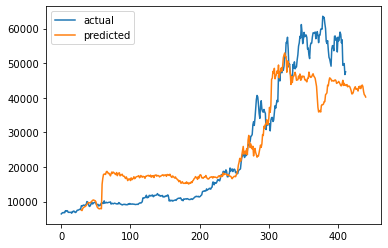

In [16]:
# Random Forest

RF = RandomForestRegressor().fit(np.vstack((trainX,valX)),np.vstack((trainY,valY))) # fit random forest

RFpredY = RF.predict(testX) # make predictions using model
RFinvpredY = testscaler.inverse_transform(concatenate((RFpredY.reshape(RFpredY.shape[0],1), testshifted.iloc[timetrail:,-1:]), axis=1))[:,0] # revert the scaling to get actual values
RFshiftedinvpredY = np.append(np.repeat(np.nan, (timefuture-1)),RFinvpredY)
actualY = testdf.iloc[timetrail:,0].values # extract actual values from original data
shiftedactualY = np.append(actualY,np.repeat(np.nan, (timefuture-1)))
RFrmse = math.sqrt(mean_squared_error(shiftedactualY[(timefuture-1):(shiftedactualY.shape[0]-(timefuture-1)),], RFshiftedinvpredY[(timefuture-1):(shiftedinvpredY.shape[0]-(timefuture-1)),])) # calculate rmse
print('Test RMSE: %.3f' % RFrmse)
                                          
# compare predicted to actual (whole test data, note that this is a daily prediction)
pyplot.plot(shiftedactualY, label='actual')
pyplot.plot(RFshiftedinvpredY, label='predicted')
pyplot.legend()
pyplot.show()

Test RMSE: 8163.843


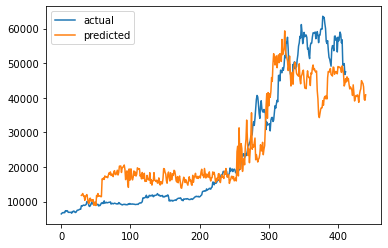

In [17]:
# XGBoost

XGB = xgb.XGBRegressor().fit(np.vstack((trainX,valX)),np.vstack((trainY,valY))) # fit XGBoost

XGBpredY = XGB.predict(testX) # make predictions using model
XGBinvpredY = testscaler.inverse_transform(concatenate((XGBpredY.reshape(XGBpredY.shape[0],1), testshifted.iloc[timetrail:,-1:]), axis=1))[:,0] # revert the scaling to get actual values
XGBshiftedinvpredY = np.append(np.repeat(np.nan, (timefuture-1)),XGBinvpredY)
actualY = testdf.iloc[timetrail:,0].values # extract actual values from original data
shiftedactualY = np.append(actualY,np.repeat(np.nan, (timefuture-1)))
XGBrmse = math.sqrt(mean_squared_error(shiftedactualY[(timefuture-1):(shiftedactualY.shape[0]-(timefuture-1)),], XGBshiftedinvpredY[(timefuture-1):(shiftedinvpredY.shape[0]-(timefuture-1)),])) # calculate rmse
print('Test RMSE: %.3f' % XGBrmse)
                                          
# compare predicted to actual (whole test data, note that this is a daily prediction)
pyplot.plot(shiftedactualY, label='actual')
pyplot.plot(XGBshiftedinvpredY, label='predicted')
pyplot.legend()
pyplot.show()

Test RMSE: 11544.905


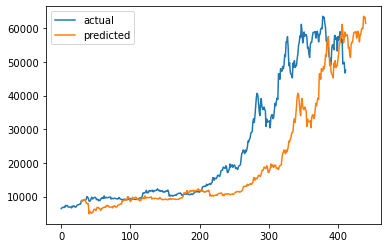

In [18]:
# NAIVE

naive = data['close'].shift(timefuture) # shift
naivY = naive.values[-testY.shape[0]:] # persist not predict
shiftednaivY = np.append(np.repeat(np.nan, (timefuture-1)),naivY)
actualY = testdf.iloc[timetrail:,0].values # extract actual values from original data
shiftedactualY = np.append(actualY,np.repeat(np.nan, (timefuture-1)))
naivrmse = math.sqrt(mean_squared_error(shiftedactualY[(timefuture-1):(shiftedactualY.shape[0]-(timefuture-1)),], shiftednaivY[(timefuture-1):(shiftednaivY.shape[0]-(timefuture-1)),])) # calculate rmse
print('Test RMSE: %.3f' % naivrmse)

# compare predicted to actual (whole test data, note that this is a daily prediction)
pyplot.plot(shiftedactualY, label='actual')
pyplot.plot(shiftednaivY, label='predicted')
pyplot.legend()
pyplot.show()

In [19]:
# PLAIN NN

# prepare LSTM model
model = Sequential()
model.add(Dense(32, input_dim=trainX.shape[1], activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=1e-3, decay=1e-5))

# fit LSTM model
history = model.fit(trainX, trainY, epochs=16, batch_size=32, validation_data=(valX, valY), verbose=1, shuffle=False)

Epoch 1/16
43/43 [==============================] - 1s 21ms/step - loss: 0.0405 - val_loss: 0.2724
Epoch 2/16
43/43 [==============================] - 0s 4ms/step - loss: 0.0658 - val_loss: 0.2819
Epoch 3/16
43/43 [==============================] - 0s 4ms/step - loss: 0.0295 - val_loss: 0.2657
Epoch 4/16
43/43 [==============================] - 0s 5ms/step - loss: 0.0286 - val_loss: 0.0562
Epoch 5/16
43/43 [==============================] - 0s 5ms/step - loss: 0.0274 - val_loss: 0.0955
Epoch 6/16
43/43 [==============================] - 0s 4ms/step - loss: 0.0243 - val_loss: 0.0498
Epoch 7/16
43/43 [==============================] - 0s 4ms/step - loss: 0.0256 - val_loss: 0.0808
Epoch 8/16
43/43 [==============================] - 0s 4ms/step - loss: 0.0216 - val_loss: 0.0498
Epoch 9/16
43/43 [==============================] - 0s 4ms/step - loss: 0.0210 - val_loss: 0.0722
Epoch 10/16
43/43 [==============================] - 0s 4ms/step - loss: 0.0179 - val_loss: 0.0502
Epoch 11/16
43/43 

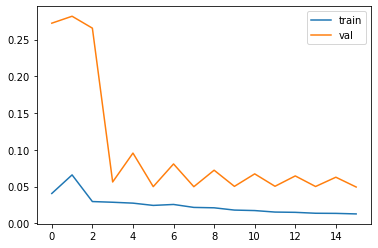

In [20]:
# plot training loss vs validation loss to check for overfitting
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

Test RMSE: 8177.956


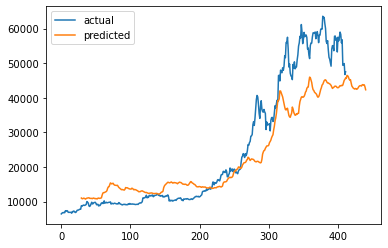

In [21]:
FCpredY = model.predict(testX) # make predictions using model
FCinvpredY = testscaler.inverse_transform(concatenate((FCpredY, testshifted.iloc[timetrail:,-1:]), axis=1))[:,0] # revert the scaling to get actual values
FCshiftedinvpredY = np.append(np.repeat(np.nan, (timefuture-1)),FCinvpredY)
actualY = testdf.iloc[timetrail:,0].values # extract actual values from original data
shiftedactualY = np.append(actualY,np.repeat(np.nan, (timefuture-1)))
FCrmse = math.sqrt(mean_squared_error(shiftedactualY[(timefuture-1):(shiftedactualY.shape[0]-(timefuture-1)),], FCshiftedinvpredY[(timefuture-1):(FCshiftedinvpredY.shape[0]-(timefuture-1)),])) # calculate rmse
print('Test RMSE: %.3f' % FCrmse)

# compare predicted to actual (whole test data, note that this is a daily prediction)
pyplot.plot(shiftedactualY, label='actual')
pyplot.plot(shiftedinvpredY, label='predicted')
pyplot.legend()
pyplot.show()

In [31]:
# RNN

# prepare SimpleRNN model
model = Sequential()
model.add(SimpleRNN(64, input_shape=(trainXsh.shape[1], trainXsh.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=1e-3, decay=1e-4))

# fit SimpleRNN model
history = model.fit(trainXsh, trainY, epochs=16, batch_size=32, validation_data=(valXsh, valY), verbose=1, shuffle=False)

Epoch 1/16
43/43 [==============================] - 1s 28ms/step - loss: 0.0184 - val_loss: 0.0606
Epoch 2/16
43/43 [==============================] - 1s 20ms/step - loss: 0.0321 - val_loss: 0.0233
Epoch 3/16
43/43 [==============================] - 1s 21ms/step - loss: 0.0145 - val_loss: 0.1440
Epoch 4/16
43/43 [==============================] - 1s 22ms/step - loss: 0.0207 - val_loss: 0.1236
Epoch 5/16
43/43 [==============================] - 1s 21ms/step - loss: 0.0441 - val_loss: 0.0402
Epoch 6/16
43/43 [==============================] - 1s 22ms/step - loss: 0.0109 - val_loss: 0.0400
Epoch 7/16
43/43 [==============================] - 1s 24ms/step - loss: 0.0099 - val_loss: 0.0321
Epoch 8/16
43/43 [==============================] - 1s 20ms/step - loss: 0.0098 - val_loss: 0.0324
Epoch 9/16
43/43 [==============================] - 1s 24ms/step - loss: 0.0086 - val_loss: 0.0342
Epoch 10/16
43/43 [==============================] - 1s 22ms/step - loss: 0.0086 - val_loss: 0.0324
Epoch 11/

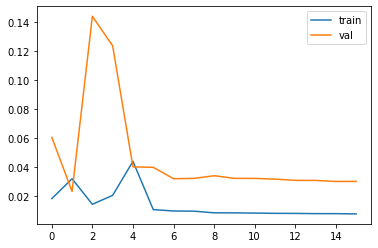

In [32]:
# plot training loss vs validation loss to check for overfitting
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

Test RMSE: 9008.080


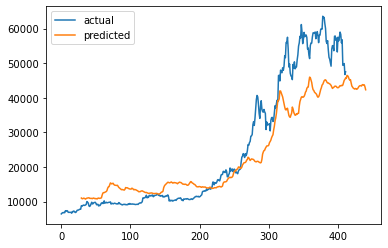

In [33]:
RNNpredY = model.predict(testXsh) # make predictions using model
RNNinvpredY = testscaler.inverse_transform(concatenate((RNNpredY, testshifted.iloc[timetrail:,-1:]), axis=1))[:,0] # revert the scaling to get actual values
RNNshiftedinvpredY = np.append(np.repeat(np.nan, (timefuture-1)),RNNinvpredY)
actualY = testdf.iloc[timetrail:,0].values # extract actual values from original data
shiftedactualY = np.append(actualY,np.repeat(np.nan, (timefuture-1)))
RNNrmse = math.sqrt(mean_squared_error(shiftedactualY[(timefuture-1):(shiftedactualY.shape[0]-(timefuture-1)),], RNNshiftedinvpredY[(timefuture-1):(RNNshiftedinvpredY.shape[0]-(timefuture-1)),])) # calculate rmse
print('Test RMSE: %.3f' % RNNrmse)

# compare predicted to actual (whole test data, note that this is a daily prediction)
pyplot.plot(shiftedactualY, label='actual')
pyplot.plot(shiftedinvpredY, label='predicted')
pyplot.legend()
pyplot.show()

In [25]:
# GRU

# prepare GRU model
model = Sequential()
model.add(GRU(32, input_shape=(trainXsh.shape[1], trainXsh.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=1e-2, decay=1e-4))

# fit SimpleRNN model
history = model.fit(trainXsh, trainY, epochs=16, batch_size=32, validation_data=(valXsh, valY), verbose=1, shuffle=False)

Epoch 1/16
43/43 [==============================] - 4s 99ms/step - loss: 0.0159 - val_loss: 0.1500
Epoch 2/16
43/43 [==============================] - 2s 41ms/step - loss: 0.0276 - val_loss: 0.0420
Epoch 3/16
43/43 [==============================] - 2s 42ms/step - loss: 0.0246 - val_loss: 0.0391
Epoch 4/16
43/43 [==============================] - 2s 42ms/step - loss: 0.0290 - val_loss: 0.0310
Epoch 5/16
43/43 [==============================] - 2s 42ms/step - loss: 0.0309 - val_loss: 0.0290
Epoch 6/16
43/43 [==============================] - 2s 43ms/step - loss: 0.0263 - val_loss: 0.0269
Epoch 7/16
43/43 [==============================] - 2s 41ms/step - loss: 0.0273 - val_loss: 0.0233
Epoch 8/16
43/43 [==============================] - 2s 42ms/step - loss: 0.0253 - val_loss: 0.0409
Epoch 9/16
43/43 [==============================] - 2s 44ms/step - loss: 0.0198 - val_loss: 0.0233
Epoch 10/16
43/43 [==============================] - 2s 43ms/step - loss: 0.0199 - val_loss: 0.0240
Epoch 11/

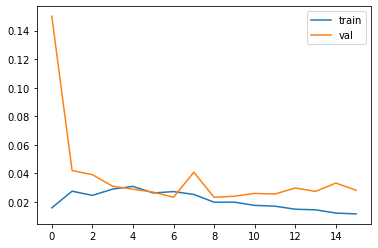

In [26]:
# plot training loss vs validation loss to check for overfitting
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

Test RMSE: 7169.670


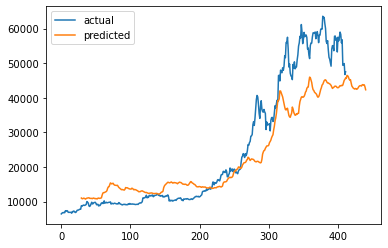

In [27]:
GRUpredY = model.predict(testXsh) # make predictions using model
GRUinvpredY = testscaler.inverse_transform(concatenate((GRUpredY, testshifted.iloc[timetrail:,-1:]), axis=1))[:,0] # revert the scaling to get actual values
GRUshiftedinvpredY = np.append(np.repeat(np.nan, (timefuture-1)),GRUinvpredY)
actualY = testdf.iloc[timetrail:,0].values # extract actual values from original data
shiftedactualY = np.append(actualY,np.repeat(np.nan, (timefuture-1)))
GRUrmse = math.sqrt(mean_squared_error(shiftedactualY[(timefuture-1):(shiftedactualY.shape[0]-(timefuture-1)),], GRUshiftedinvpredY[(timefuture-1):(GRUshiftedinvpredY.shape[0]-(timefuture-1)),])) # calculate rmse
print('Test RMSE: %.3f' % GRUrmse)

# compare predicted to actual (whole test data, note that this is a daily prediction)
pyplot.plot(shiftedactualY, label='actual')
pyplot.plot(shiftedinvpredY, label='predicted')
pyplot.legend()
pyplot.show()